In [35]:
from __future__ import print_function

# We'll need numpy and matplotlib for plotting our results
import numpy as np
import matplotlib.pyplot as plt

# A least squares fitting algorithm from scipy
from scipy.optimize.minpack import leastsq

# DiffPy-CMI modules for building a fitting recipe
from diffpy.Structure import loadStructure
from diffpy.srfit.pdf import PDFContribution
from diffpy.srfit.fitbase import FitRecipe, FitResults

In [61]:
# Files containing our experimental data and structure file
dataFile = "/home/ABTLUS/victor.secco/data_processing/ED/CdSe_ePDF/W1/Jun_2024/Gr/gr_PCA_CdSe_W1.grobs"
structureFile = "/home/ABTLUS/victor.secco/data_processing/Banco de Dados Cristalográficos/CdSe_Zinc_Blende_CollCode53954.cif"
spaceGroup = "F -4 3 m"

# The first thing to construct is a contribution. Since this is a simple
# example, the contribution will simply contain our PDF data and an associated
# structure file. We'll give it the name "nickel"
niPDF = PDFContribution("CdSe")

# Load the data and set the r-range over which we'll fit
niPDF.loadData(dataFile)
niPDF.setCalculationRange(xmin=1, xmax=20, dx=0.01)

# Add the structure from our cif file to the contribution
cdseStructure = loadStructure(structureFile)
niPDF.addStructure("CdSe", cdseStructure)

# The FitRecipe does the work of calculating the PDF with the fit variable
# that we give it.
niFit = FitRecipe()

# give the PDFContribution to the FitRecipe
niFit.addContribution(niPDF)

# Configure the fit variables and give them to the recipe.  We can use the
# srfit function constrainAsSpaceGroup to constrain the lattice and ADP
# parameters according to the Fm-3m space group.
from diffpy.srfit.structure import constrainAsSpaceGroup
spaceGroupParams = constrainAsSpaceGroup(niPDF.CdSe.phase, spaceGroup)

print("Space group parameters are:",
      ', '.join(p.name for p in spaceGroupParams))
print()
# We can now cycle through the parameters and activate them in the recipe as
# variables
for par in spaceGroupParams.latpars:
    niFit.addVar(par)
# Set initial value for the ADP parameters, because CIF had no ADP data.
for par in spaceGroupParams.adppars:
    niFit.addVar(par, value=0.005)

niFit.addVar(niPDF.scale, 1)
niFit.addVar(niPDF.CdSe.delta2, 5)

# We fix Qdamp based on prior information about our beamline.
niFit.addVar(niPDF.qdamp, 0.03, fixed=True)

Space group parameters are: a, Uiso_0, Uiso_4



In [66]:
# As usual, we add variables for the overall scale of the PDF and a delta2
# parameter for correlated motion of neighboring atoms.
niPDF.setScatteringType("E")

# Turn off printout of iteration number.
niFit.clearFitHooks()

print("  variables:", niFit.names)
print("  initial values:", niFit.values)
leastsq(niFit.residual, niFit.values)
print("  final values:", niFit.values)
print()

# Obtain and display the fit results.
niResults = FitResults(niFit)
print("FIT RESULTS\n")
print(niResults)

# Plot the observed and refined PDF.

# Get the experimental data from the recipe
r = niFit.CdSe.profile.x
gobs = niFit.CdSe.profile.y

# Get the calculated PDF and compute the difference between the calculated and
# measured PDF
gcalc = niFit.CdSe.evaluate()
baseline = 1.1 * gobs.min()
gdiff = gobs - gcalc

# Plot!

  variables: ['a', 'Uiso_0', 'Uiso_4', 'scale', 'delta2']
  initial values: [6.04443272 0.759819   0.19938684 0.84345033 6.76544945]
  final values: [6.04443239 0.75981914 0.19938684 0.84345026 6.765449  ]

FIT RESULTS

Some quantities invalid due to missing profile uncertainty
Overall (Chi2 and Reduced Chi2 invalid)
------------------------------------------------------------------------------
Residual       652.95031645
Contributions  652.95031645
Restraints     0.00000000
Chi2           652.95031645
Reduced Chi2   0.34438308
Rw             1.00000000

Variables (Uncertainties invalid)
------------------------------------------------------------------------------
Uiso_0  7.59819145e-01 +/- nan
Uiso_4  1.99386844e-01 +/- nan
a       6.04443239e+00 +/- nan
delta2  6.76544900e+00 +/- nan
scale   8.43450264e-01 +/- nan

Fixed Variables
------------------------------------------------------------------------------
qdamp  3.00000000e-02

Variable Correlations greater than 25% (Correlations

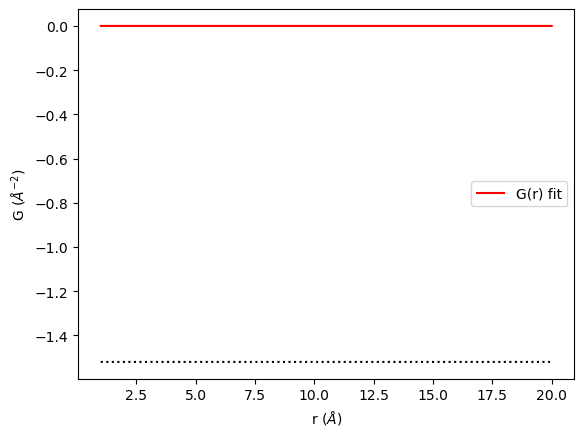

In [67]:
plt.figure()
#plt.plot(r, gobs, 'bo', label="G(r) data",
#         markerfacecolor='none', markeredgecolor='b')
plt.plot(r, gcalc, 'r-', label="G(r) fit")
#plt.plot(r, gdiff + baseline, 'g-', label="G(r) diff")
plt.plot(r, np.zeros_like(r) + baseline, 'k:')
plt.xlabel(r"r ($\AA$)")
plt.ylabel(r"G ($\AA^{-2}$)")
plt.legend()

plt.show()

In [ ]:
from diffpy.srreal.scatteringfactortable import SFTXray
from diffpy.srreal.pdfcalculator import PDFCalculator
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing')
from mypackages.electron_scattering_table import SFTElectron


pcx = PDFCalculator(qmax=16.88, rmin=1, rmax=10)
pcx.scatteringfactortable = SFTXray()

pce = PDFCalculator(qmax=16.88, rmin=1, rmax=10)
pce.scatteringfactortable = SFTElectron()

from matplotlib.pyplot import *
%matplotlib inline

figure(1);
plot(*pcx(cdseStructure), label='x-ray')
plot(*pce(cdseStructure), label='electrons')
legend();